In [19]:
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

In [2]:
from torchvision import datasets as Datasets
from torchvision import transforms as T

mnist_train_transform = T.Compose([
    T.ToTensor(),
])

mnist_test_transform = T.Compose([
    T.ToTensor(),
])

train_dataset = Datasets.MNIST(root='../../autoencoder', train=True, download=False, transform=mnist_train_transform)
test_dataset = Datasets.MNIST(root='../../autoencoder', train=False, download=False, transform=mnist_test_transform)

In [3]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=16, pin_memory=True)

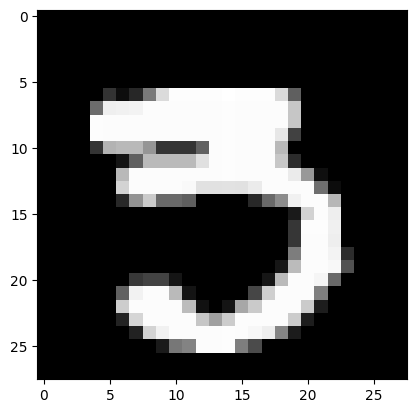

In [5]:
# Show image from train loader
img, _ = next(iter(train_loader))
plt.imshow(img[0][0], cmap='gray')

In [68]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
        )
        
        self.mean_predictor = nn.Linear(128, 2)
        self.logvar_predictor = nn.Linear(128, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        mean = self.mean_predictor(x)
        logvar = self.logvar_predictor(x)

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        x = mean + eps * std
        x = self.decoder(x)

        return mean, logvar, x.view(-1, 1, 28, 28)
    
    def recon_loss(self, recon, x):
        return F.binary_cross_entropy(recon, x, reduction='sum') / x.size(0)

    def kl_loss(self, mean, logvar):
        return -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)

In [80]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [81]:
epochs = 5
for epoch in range(epochs):
    model.train()
    tqdm_loader = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
    for x, _ in tqdm_loader:
        x = x.to(device)
        mean, logvar, recon = model(x)
        recon_loss = model.recon_loss(recon, x)
        kl_loss = model.kl_loss(mean, logvar)
        loss = recon_loss + kl_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tqdm_loader.set_postfix(loss=loss.item(), recon_loss=recon_loss.item(), kl_loss=kl_loss.item())

Epoch 5/5: 100%|██████████| 469/469 [00:01<00:00, 271.68it/s, kl_loss=3.44, loss=147, recon_loss=143]


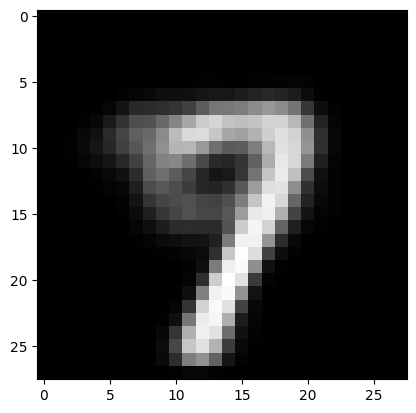

In [84]:
# Get reconstruction of test image
model.eval()
img, _ = next(iter(test_loader))
img = img.to(device)
_, _, recon = model(img)
plt.imshow(recon[0][0].detach().cpu().numpy(), cmap='gray')

In [85]:
def plot_latent_space(model, scale=1, n=20, digit_size=28, figsize=15):
    figure = np.zeros((digit_size * n, digit_size * n))

    # Construct grid of latent variable values
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    # Decode for each square in the grid
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decoder(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size).cpu().detach().numpy()
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    # Plot figure
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

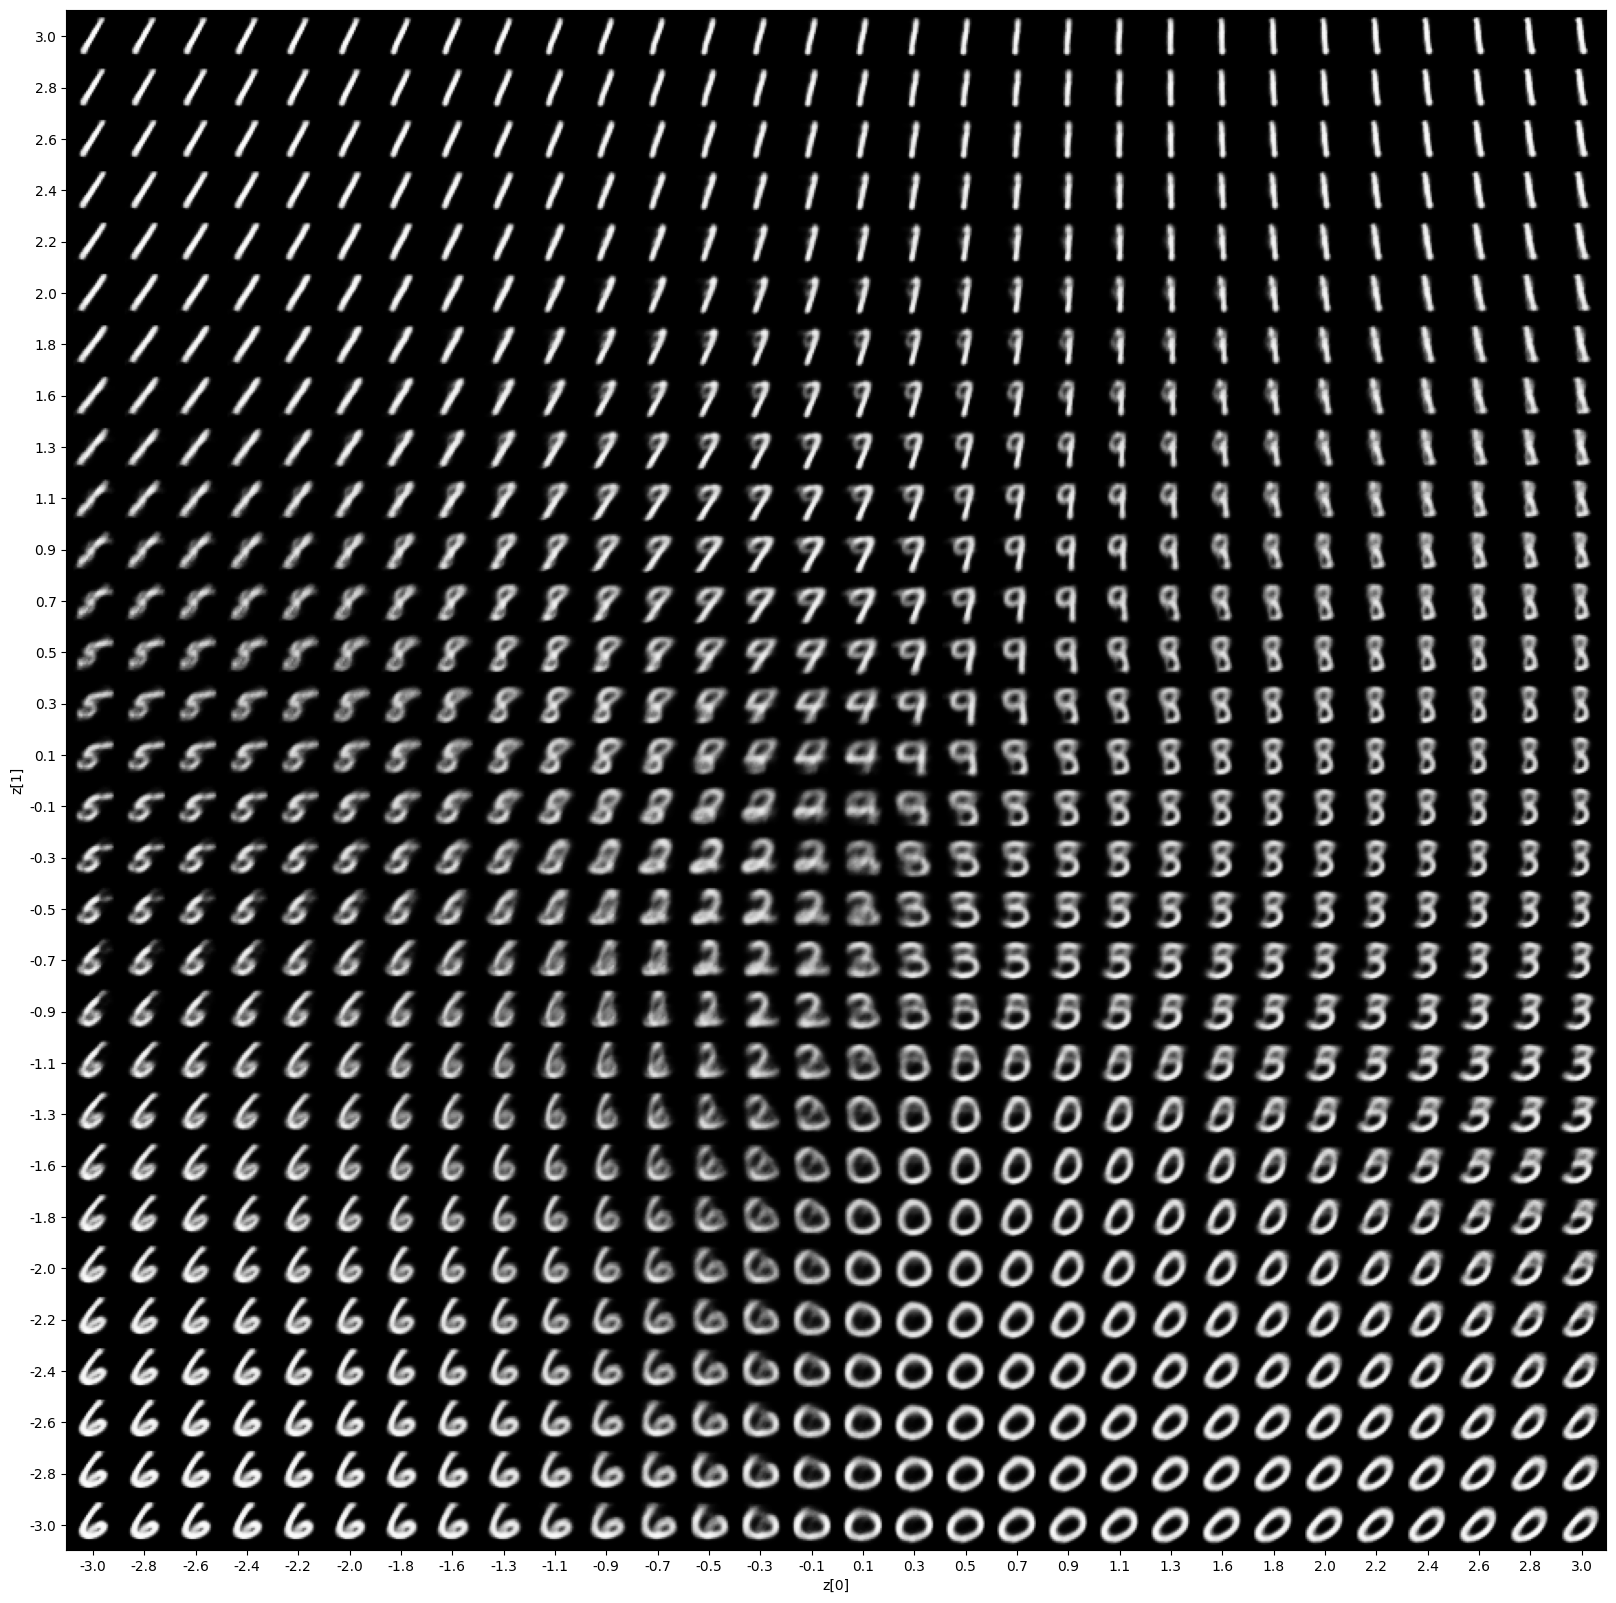

In [87]:
plot_latent_space(model, scale=3, n=30, digit_size=28, figsize=20)